In [1]:
# Install the required libraries.
!pip install pafy youtube-dl moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.9 MB/s eta 0:00:00


In [2]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline

In [25]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Download the dataset

In [4]:
# Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF50/HorseRace/v_HorseRace_g16_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g16_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c03.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c04.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g17_c05.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c01.avi                       23%  OK 
Extracting  UCF50/HorseRace/v_HorseRace_g18_c02.avi                       23%  OK 
Extracting  UCF50/HorseRace/v

## Visualize 20 videos from the dataset

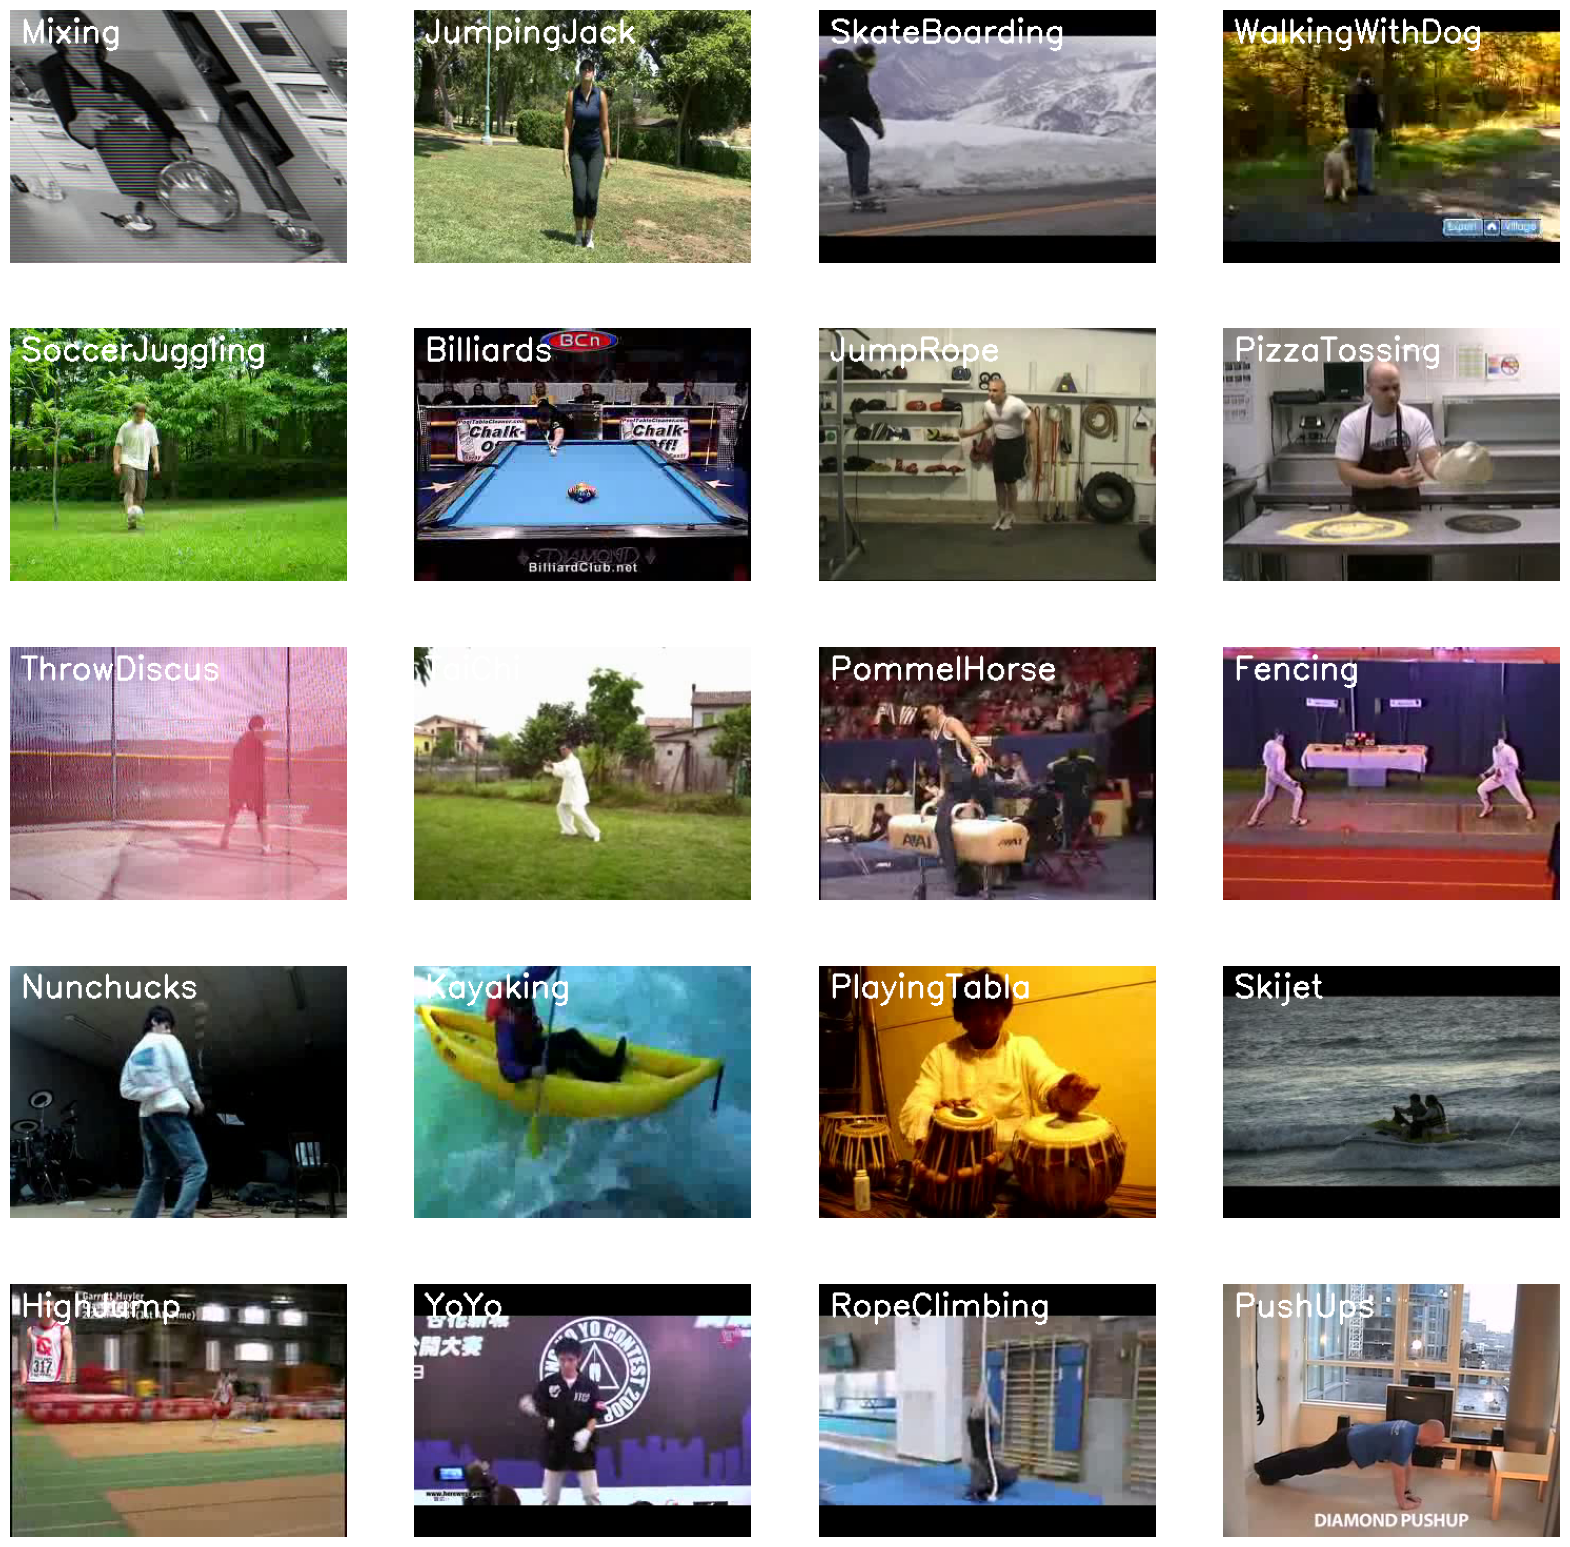

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [5]:
len(all_classes_names)

50

In [6]:
all_classes_names

['BenchPress',
 'HorseRiding',
 'RockClimbingIndoor',
 'VolleyballSpiking',
 'JumpRope',
 'PlayingGuitar',
 'TennisSwing',
 'HorseRace',
 'BaseballPitch',
 'GolfSwing',
 'HulaHoop',
 'PlayingTabla',
 'Billiards',
 'PullUps',
 'MilitaryParade',
 'Skijet',
 'ThrowDiscus',
 'WalkingWithDog',
 'SoccerJuggling',
 'JugglingBalls',
 'Punch',
 'PommelHorse',
 'PlayingPiano',
 'Nunchucks',
 'PlayingViolin',
 'Kayaking',
 'SalsaSpin',
 'Swing',
 'Basketball',
 'CleanAndJerk',
 'JumpingJack',
 'YoYo',
 'PoleVault',
 'Biking',
 'TaiChi',
 'Rowing',
 'Lunges',
 'PushUps',
 'JavelinThrow',
 'Drumming',
 'HighJump',
 'Mixing',
 'RopeClimbing',
 'PizzaTossing',
 'SkateBoarding',
 'Skiing',
 'TrampolineJumping',
 'BreastStroke',
 'Diving',
 'Fencing']

## Data Pre-processing

In [7]:
# Configure the target dimensions for preprocessing video frames
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Define how many consecutive frames from each video will be used as input to create temporal sequences
SEQUENCE_LENGTH = 20

# Set the path to the root directory where the UCF50 action recognition dataset is stored
DATASET_DIR = "UCF50"

# Build a list of action class names for model training - using the first 20 classes from the dataset for quicker training
CLASSES_LIST = []
for i in range(10):
  CLASSES_LIST.append(all_classes_names[i])

In [8]:
import os

# Path to dataset
DATASET_DIR = "UCF50"

# Automatically get class names from folder names
CLASSES_LIST = sorted(CLASSES_LIST)

print("Classes found:", CLASSES_LIST)
print("Total classes:", len(CLASSES_LIST))

Classes found: ['BaseballPitch', 'BenchPress', 'GolfSwing', 'HorseRace', 'HorseRiding', 'JumpRope', 'PlayingGuitar', 'RockClimbingIndoor', 'TennisSwing', 'VolleyballSpiking']
Total classes: 10


In [9]:
def extract_video_frames(video_path):
    # Initialize an empty list to collect processed frames from the video
    frames_list = []

    # Open the video file for reading frames
    video_reader = cv2.VideoCapture(video_path)

    # Retrieve the total number of frames available in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Determine the interval for frame sampling to evenly select frames across the video
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Loop through the required number of frames for the sequence
    for frame_counter in range(SEQUENCE_LENGTH):
        # Move to the target frame position based on the calculated interval
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Attempt to read the frame at the current position
        success, frame = video_reader.read()

        # If reading fails, exit the loop early to avoid errors
        if not success:
            break

        # Resize the frame to the model's expected input dimensions
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Scale pixel values to the [0, 1] range for normalization
        normalized_frame = resized_frame / 255

        # Add the normalized frame to the list
        frames_list.append(normalized_frame)

    # Close the video file and release resources
    video_reader.release()

    # Return the list of processed frames for further use
    return frames_list

In [10]:
def build_video_dataset():
    # Initialize lists to store extracted features, corresponding labels, and video file paths
    features = []
    labels = []
    video_files_paths = []

    # Loop through each class in the provided class list
    for class_index, class_name in enumerate(CLASSES_LIST):
        # Print the class name currently being processed for tracking progress
        print(f'Extracting Data of Class: {class_name}')

        # Retrieve all video file names within the current class directory
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Process each video file in the class directory
        for file_name in files_list:
            # Build the full path to the video file
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract a sequence of frames from the video using the frame extraction utility
            frames = extract_video_frames(video_file_path)

            # Only include videos with the expected number of frames for consistency
            if len(frames) == SEQUENCE_LENGTH:
                # Store the extracted frames, label index, and file path in their respective lists
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Convert lists to numpy arrays for efficient processing and compatibility with ML models
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the dataset: features, labels, and file paths for further use
    return features, labels, video_files_paths


In [11]:
# Create the dataset.
features, labels, video_files_paths = build_video_dataset()

Extracting Data of Class: BaseballPitch
Extracting Data of Class: BenchPress
Extracting Data of Class: GolfSwing
Extracting Data of Class: HorseRace
Extracting Data of Class: HorseRiding
Extracting Data of Class: JumpRope
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: RockClimbingIndoor
Extracting Data of Class: TennisSwing
Extracting Data of Class: VolleyballSpiking


In [12]:
# Transform integer class labels into one-hot encoded format for neural network training (y labels)
one_hot_encoded_labels = to_categorical(labels)

In [13]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25,
                                                                            shuffle = True, random_state = seed_constant)

## Model_1: ConvLSTM 

In [14]:
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, Dropout, Flatten, Dense, TimeDistributed

def build_convlstm_network():
    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    model.summary()

    return model


In [15]:
# Construct the required convlstm model.
convlstm_model = build_convlstm_network()

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 20, 3, 3, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        28,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,810 (241.45 KB)

 Trainable params: 61,810 (241.45 KB)

 Non-trainable params: 0 (0.00 B)

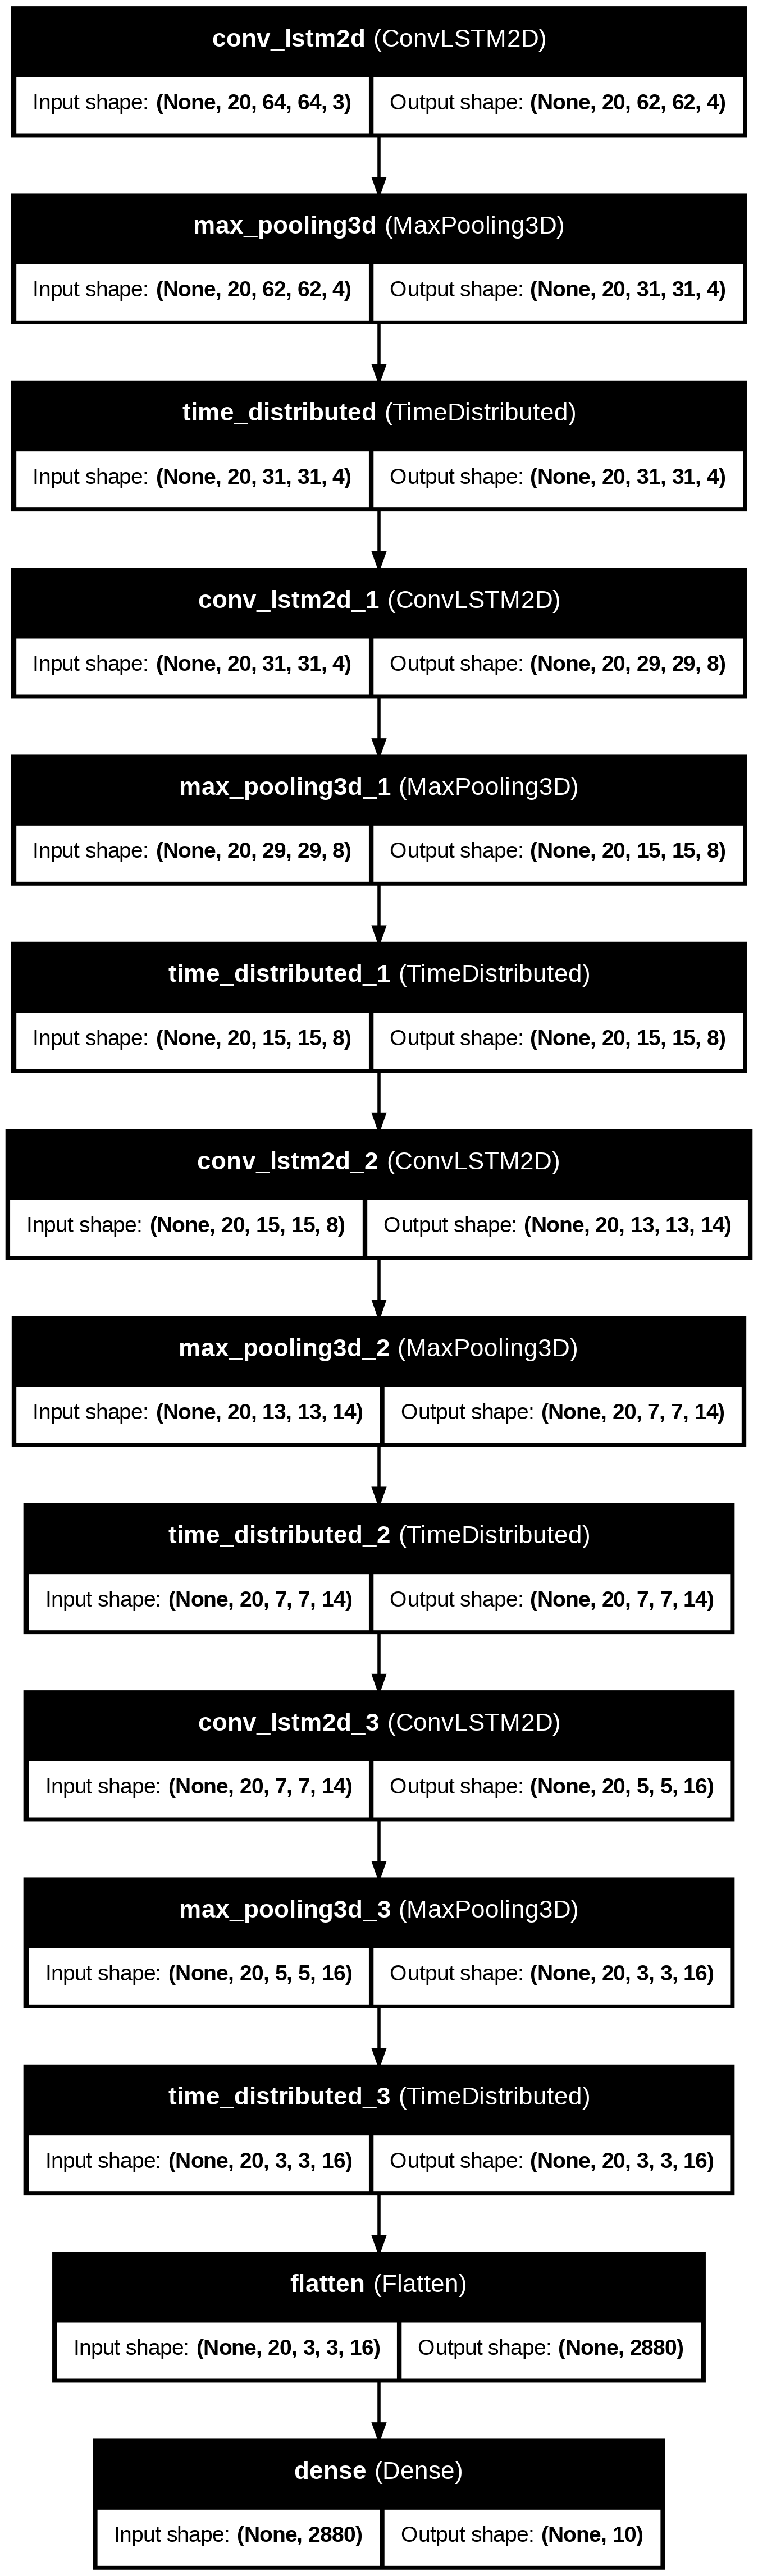

In [16]:
# Plot the model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [17]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)


convlstm_model.compile(loss = 'categorical_crossentropy',
                       optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])


Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 96s 70ms/step - accuracy: 0.1403 - loss: 2.2590 - val_accuracy: 0.4649 - val_loss: 1.4948
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.4621 - loss: 1.5411 - val_accuracy: 0.5482 - val_loss: 1.1727
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.5809 - loss: 1.2167 - val_accuracy: 0.6491 - val_loss: 0.9224
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6799 - loss: 0.9281 - val_accuracy: 0.6754 - val_loss: 0.9246
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7772 - loss: 0.6766 - val_accuracy: 0.7149 - val_loss: 0.8187
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.7675 - loss: 0.5910 - val_accuracy: 0.6886 - val_loss: 0.9193
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.8280 - loss: 0.4879 - val_accuracy: 0.8421 - val_loss: 0.6530
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.8744 - loss: 0.3409 - 

In [18]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.7795 - loss: 0.8149


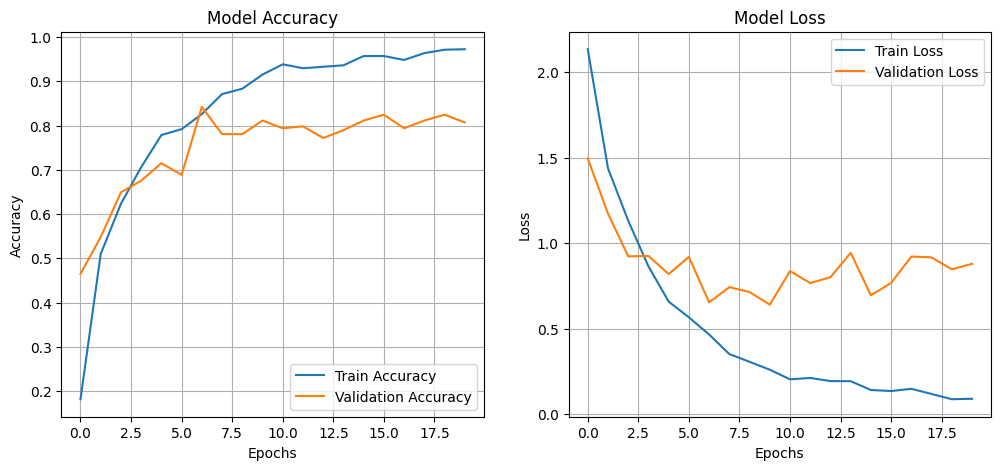

In [19]:
# Extract history values
history = convlstm_model_training_history

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
def predict_video_class(video_path, model, class_list):
    # Extract frames
    frames = extract_video_frames(video_path)

    if len(frames) != SEQUENCE_LENGTH:
        print(f"[WARNING] Video '{video_path}' skipped due to insufficient frames ({len(frames)}).")
        return None

    # Convert to numpy array and add batch dimension
    input_data = np.expand_dims(np.array(frames), axis=0)  # Shape: (1, SEQUENCE_LENGTH, H, W, 3)

    # Make prediction
    predictions = model.predict(input_data)

    # Get class index
    predicted_index = np.argmax(predictions)

    # Get class name
    predicted_class = class_list[predicted_index]

    return predicted_class


In [22]:
predict_video_class('/content/UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi',
                    convlstm_model,
                    CLASSES_LIST)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


'BaseballPitch'

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step


<Figure size 1000x1000 with 0 Axes>

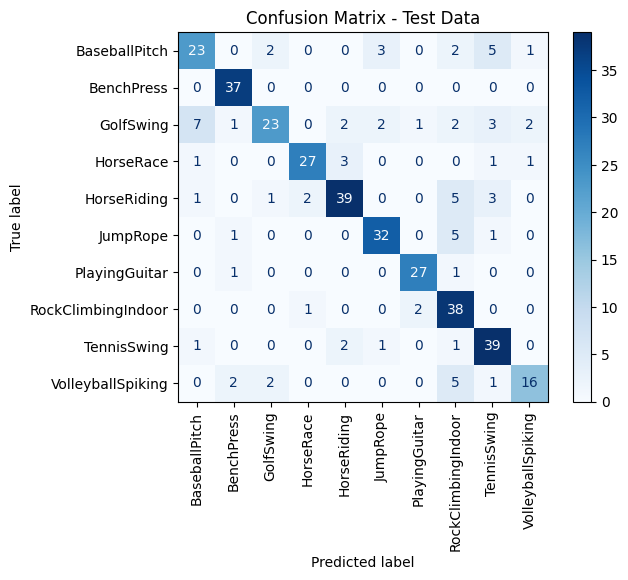

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = convlstm_model.predict(features_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices from one-hot encoded labels
y_true = np.argmax(labels_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Data")
plt.show()

## Model 2: LRCN 

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM

def create_LRCN_model():
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()

    return model

LRCN_model = create_LRCN_model()

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,258 (286.16 KB)

 Trainable params: 73,258 (286.16 KB)

 Non-trainable params: 0 (0.00 B)

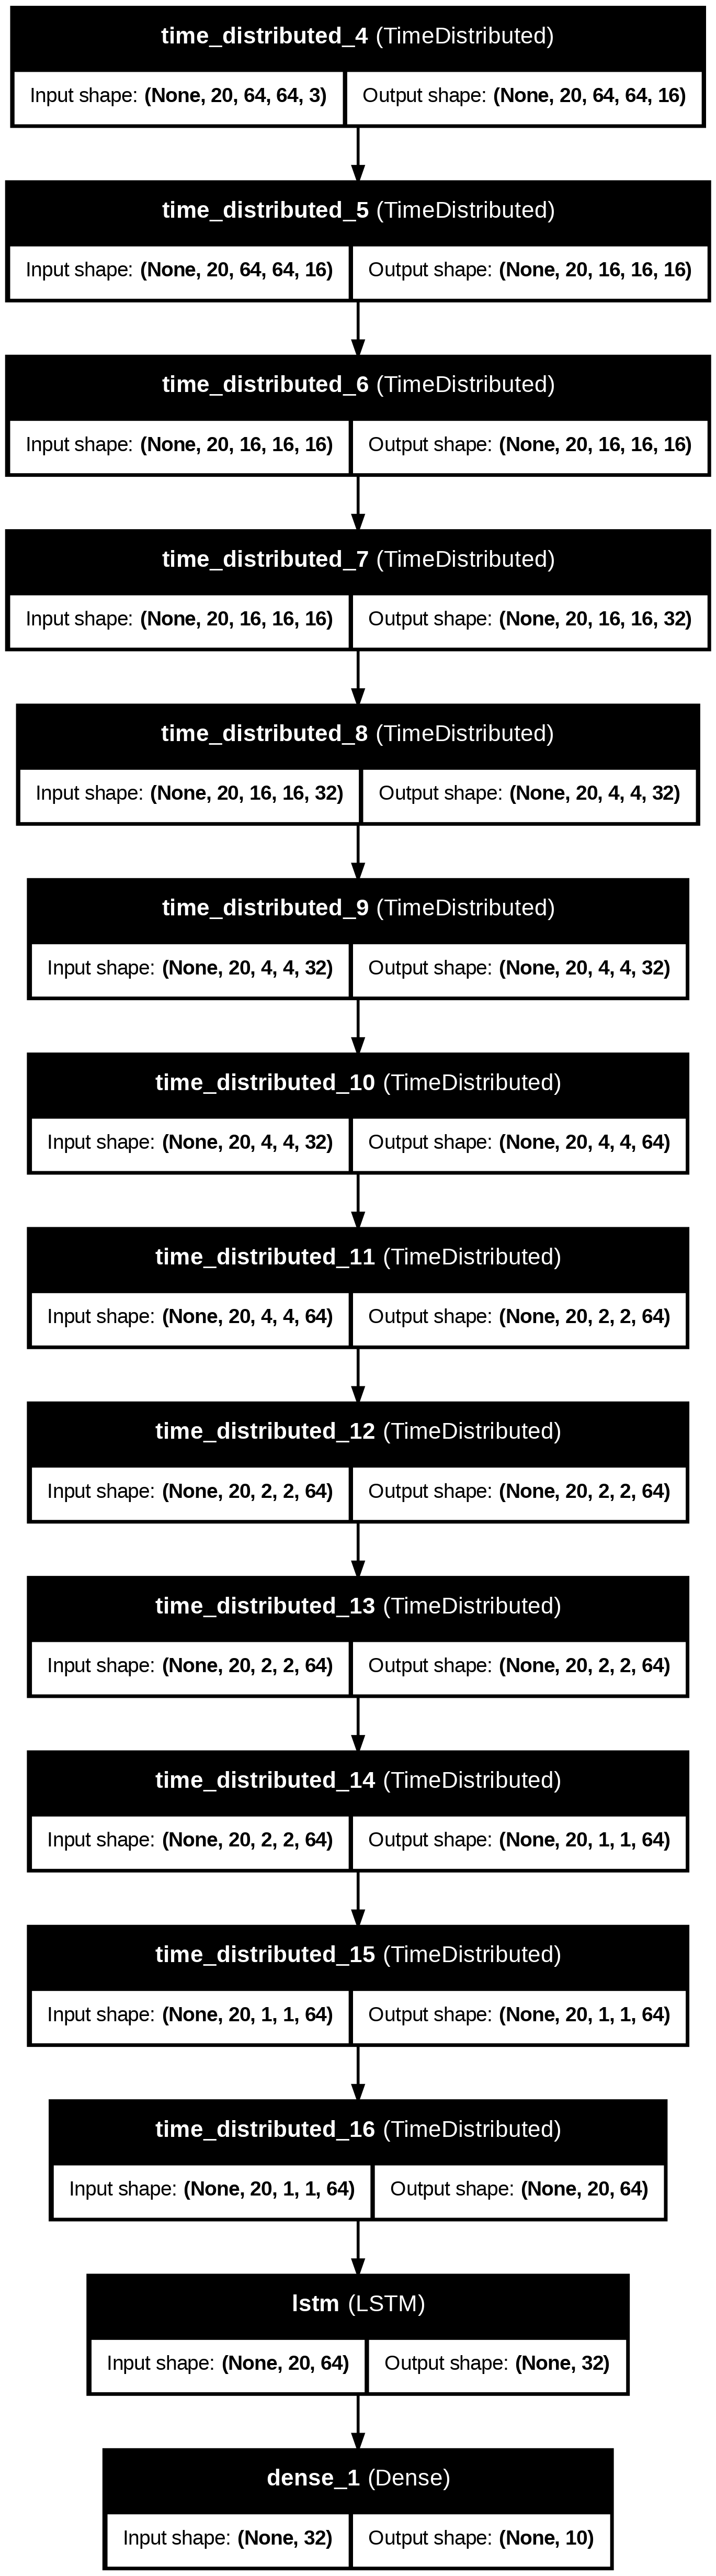

In [28]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [29]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - accuracy: 0.1334 - loss: 2.3080 - val_accuracy: 0.1491 - val_loss: 2.2465
Epoch 2/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.1939 - loss: 2.1773 - val_accuracy: 0.2325 - val_loss: 1.9247
Epoch 3/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.3302 - loss: 1.8500 - val_accuracy: 0.4123 - val_loss: 1.8009
Epoch 4/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.4203 - loss: 1.6913 - val_accuracy: 0.5000 - val_loss: 1.3711
Epoch 5/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.5351 - loss: 1.3569 - val_accuracy: 0.6140 - val_loss: 1.2807
Epoch 6/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.6095 - loss: 1.1400 - val_accuracy: 0.5789 - val_loss: 1.2278
Epoch 7/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.6581 - loss: 1.0418 - val_accuracy: 0.7281 - val_loss: 0.9279
Epoch 8/70
227/227 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.6855 - loss: 0.9368 - 

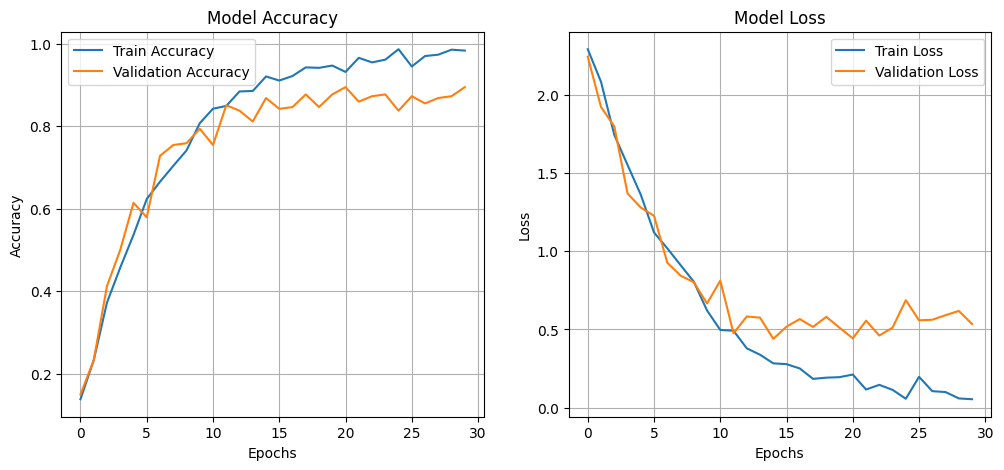

In [30]:
# Extract history values
history = LRCN_model_training_history

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [31]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8162 - loss: 0.6279


In [32]:
predict_video_class('/content/UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi',
                    LRCN_model,
                    CLASSES_LIST)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'BaseballPitch'

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step


<Figure size 1000x1000 with 0 Axes>

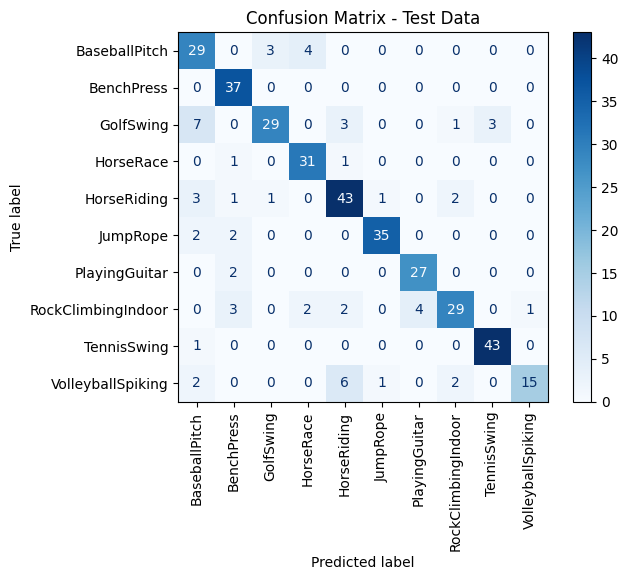

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = LRCN_model.predict(features_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices from one-hot encoded labels
y_true = np.argmax(labels_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Data")
plt.show()

## Model 3: 3d-CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_3d_cnn_classification_model(
    input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
    ):

    inputs = layers.Input(shape=input_shape)

    # 3D CNN block 1
    x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)

    # 3D CNN block 2
    x = layers.Conv3D(64, kernel_size=(3, 3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # 3D CNN block 3
    x = layers.Conv3D(128, kernel_size=(3, 3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # 3D CNN block 4
    x = layers.Conv3D(256, kernel_size=(3, 3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    # Global pooling
    x = layers.GlobalAveragePooling3D()(x)

    # Fully connected layers
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="3D_CNN_Video_Classifier")
    return model

# Build model for your dataset
cnn3d_model = build_3d_cnn_classification_model(
    input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
)

# Compile
cnn3d_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = cnn3d_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

# Evaluate
test_loss, test_acc = cnn3d_model.evaluate(features_test, labels_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.1304 - loss: 2.3148 - val_accuracy: 0.2105 - val_loss: 2.2484
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.2200 - loss: 2.2096 - val_accuracy: 0.2719 - val_loss: 1.8832
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.2866 - loss: 1.9378 - val_accuracy: 0.3377 - val_loss: 1.7337
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3097 - loss: 1.8326 - val_accuracy: 0.3816 - val_loss: 1.6129
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3763 - loss: 1.6931 - val_accuracy: 0.4342 - val_loss: 1.5213
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4194 - loss: 1.5243 - val_accuracy: 0.4737 - val_loss: 1.2812
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5207 - loss: 1.2957 - val_accuracy: 0.5570 - val_loss: 1.2782
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.5685 - loss: 1.2006 - val_acc

In [35]:
predict_video_class('/content/UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi',
                    cnn3d_model,
                    CLASSES_LIST)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 811ms/step


'BaseballPitch'

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


<Figure size 1000x1000 with 0 Axes>

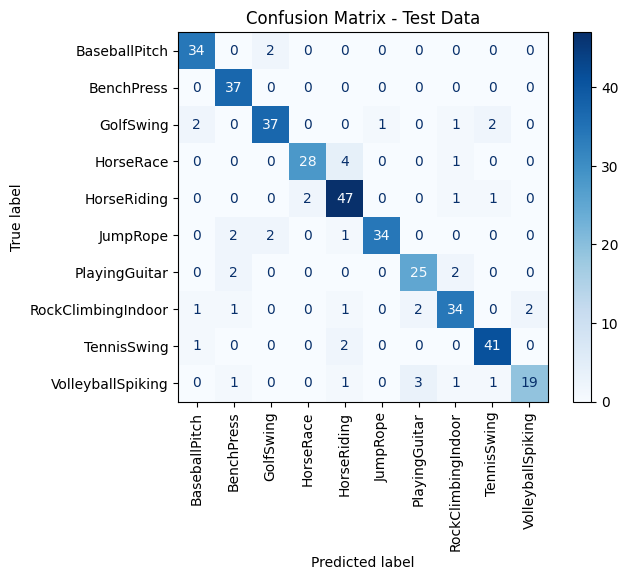

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = cnn3d_model.predict(features_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices from one-hot encoded labels
y_true = np.argmax(labels_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Data")
plt.show()

## Model 4: CNN+LSTM

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_lstm_model(
    input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
):
    inputs = layers.Input(shape=input_shape)

    # 3D CNN block 1
    x = layers.Conv3D(32, (3, 3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling3D((1, 2, 2))(x)

    # 3D CNN block 2
    x = layers.Conv3D(64, (3, 3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)

    # 3D CNN block 3
    x = layers.Conv3D(128, (3, 3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling3D((2, 2, 2))(x)

    # Flatten spatial dims, keep time (TimeDistributed)
    x = layers.TimeDistributed(layers.Flatten())(x)

    # LSTM layers
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(256)(x)

    # Dense layers
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Output
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, outputs, name="3D_CNN_LSTM_Classifier")


# Build model for your dataset
cnn_lstm_model = build_cnn_lstm_model(
    input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
)

# Compile
cnn_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Summary
cnn_lstm_model.summary()

Model: "3D_CNN_LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 20, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 20, 64, 64, 32) │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 20, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 20, 32, 32, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 10, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 10, 16, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 5, 8, 8, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 5, 8192)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │     4,260,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,002,250 (19.08 MB)

 Trainable params: 5,002,250 (19.08 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Train
history_cnn_lstm = cnn_lstm_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)

# Evaluate
test_loss2, test_acc2 = cnn_lstm_model.evaluate(features_test, labels_test)
print(f"Test Accuracy: {test_acc2:.2f}")

Epoch 1/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.1205 - loss: 2.3129 - val_accuracy: 0.1053 - val_loss: 2.3009
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.1525 - loss: 2.2776 - val_accuracy: 0.1404 - val_loss: 2.2115
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.2708 - loss: 2.0911 - val_accuracy: 0.3947 - val_loss: 1.8676
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4148 - loss: 1.7776 - val_accuracy: 0.5439 - val_loss: 1.3784
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5546 - loss: 1.2511 - val_accuracy: 0.5877 - val_loss: 1.2935
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.6273 - loss: 1.0714 - val_accuracy: 0.6754 - val_loss: 1.0546
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7430 - loss: 0.8375 - val_accuracy: 0.6579 - val_loss: 1.2816
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.7624 - loss: 0.6495 - val_acc

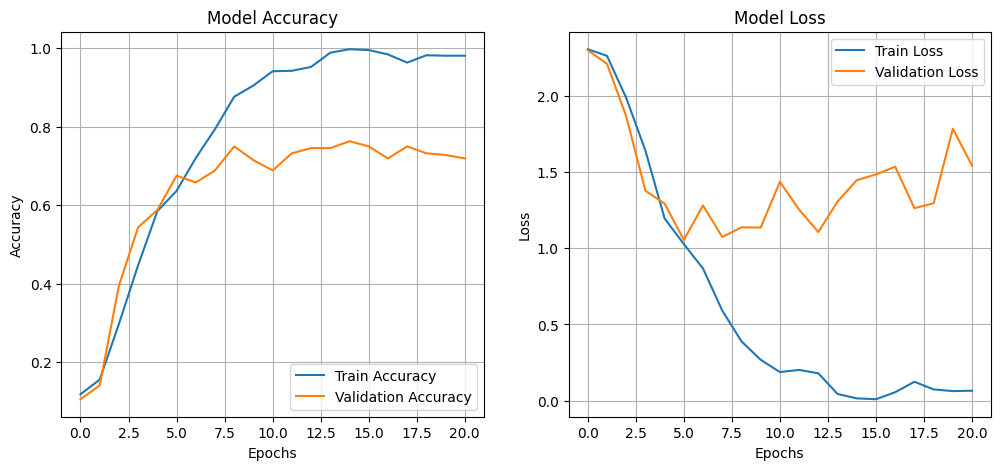

In [39]:
# Extract history values
history = history_cnn_lstm

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [40]:
# Evaluate the trained model.
model_evaluation_history = cnn_lstm_model.evaluate(features_test, labels_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6301 - loss: 1.0794


In [41]:
predict_video_class('/content/UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi',
                    cnn_lstm_model,
                    CLASSES_LIST)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


'BaseballPitch'

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


<Figure size 1000x1000 with 0 Axes>

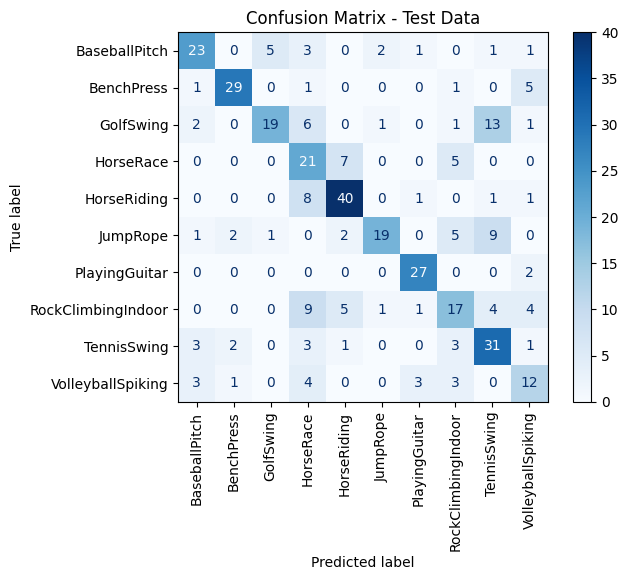

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = cnn_lstm_model.predict(features_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices from one-hot encoded labels
y_true = np.argmax(labels_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Data")
plt.show()

In [ ]:
from tensorflow.keras import layers, models

def build_gru_video_model(
    input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
):
    inputs = layers.Input(shape=input_shape)

    # Flatten each frame with TimeDistributed
    x = layers.TimeDistributed(layers.Flatten())(inputs)  # Shape: (batch, SEQ, IMAGE_HEIGHT*IMAGE_WIDTH*3)

    # GRU layers
    x = layers.GRU(128, return_sequences=True)(x)
    x = layers.GRU(256)(x)

    # Dense + Dropout
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # Output
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="GRU_Video_Classifier")
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


gru_model = build_gru_video_model(
    input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    num_classes=len(CLASSES_LIST)
)
gru_model.summary()


history_gru = gru_model.fit(
    x=features_train,
    y=labels_train,
    epochs=50,
    batch_size=4,
    validation_split=0.2,
    callbacks=[early_stopping_callback]
)


test_loss_gru, test_acc_gru = gru_model.evaluate(features_test, labels_test)
print(f"GRU Test Accuracy: {test_acc_gru:.2f}")

In [ ]:
# Extract history values
history = history_gru

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Evaluate the trained model.
model_evaluation_history = gru_model.evaluate(features_test, labels_test)

In [ ]:
predict_video_class('/content/UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi',
                    gru_model,
                    CLASSES_LIST)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = gru_model.predict(features_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class indices from one-hot encoded labels
y_true = np.argmax(labels_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES_LIST)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix - Test Data")
plt.show()